In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# reload the module after changed
%load_ext autoreload
%autoreload 2
import torch
from utilities3 import *
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

PATH = '/home/liux0t/FMM/MgNO/model/MgNO_DCpipe2023-09-29 12:15:52.608014.pt' #'/home/liux0t/FMM/model/MgNet2darcy20c62023-08-28.pt' #
model = torch.load(PATH)
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MgNO_DC(
  (conv_list): ModuleList(
    (0): MgConv_DC(
      (RTlayers): ModuleList(
        (0): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (4): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (layer0): Sequential(
        (0): MgIte_init(
          (S): Conv2d(2, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (post_smooth_layer0): Sequential(
        (0): Identity()
      )
      (layer1): Sequential(
        (0): Restrict(
          (Pi): Conv2d(24, 24, k

In [4]:

################################################################
# configs
################################################################
INPUT_X = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_X.npy'
INPUT_Y = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_Y.npy'
OUTPUT_Sigma = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_Q.npy'

ntrain = 1000
ntest = 200
N = 1200

batch_size = 20
learning_rate = 0.001

epochs = 501
step_size = 100
gamma = 0.5

modes = 12
width = 32

r1 = 1
r2 = 1
s1 = int(((129 - 1) / r1) )
s2 = int(((129 - 1) / r2) )

################################################################
# load data and data normalization
################################################################
inputX = np.load(INPUT_X)
inputX = torch.tensor(inputX, dtype=torch.float)
inputY = np.load(INPUT_Y)
inputY = torch.tensor(inputY, dtype=torch.float)
input = torch.stack([inputX, inputY], dim=-1)

output = np.load(OUTPUT_Sigma)[:, 0]
output = torch.tensor(output, dtype=torch.float)

x_train = input[:N][:ntrain, ::r1, ::r2][:, :s1, :s2]
y_train = output[:N][:ntrain, ::r1, ::r2][:, :s1, :s2]
x_test = input[:N][-ntest:, ::r1, ::r2][:, :s1, :s2]
y_test = output[:N][-ntest:, ::r1, ::r2][:, :s1, :s2]
x_train = x_train.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)


In [6]:
out = model(x_train[0:1].to(device))

In [10]:
pred = out.squeeze().detach().cpu().numpy()
pred.shape

(128, 128)

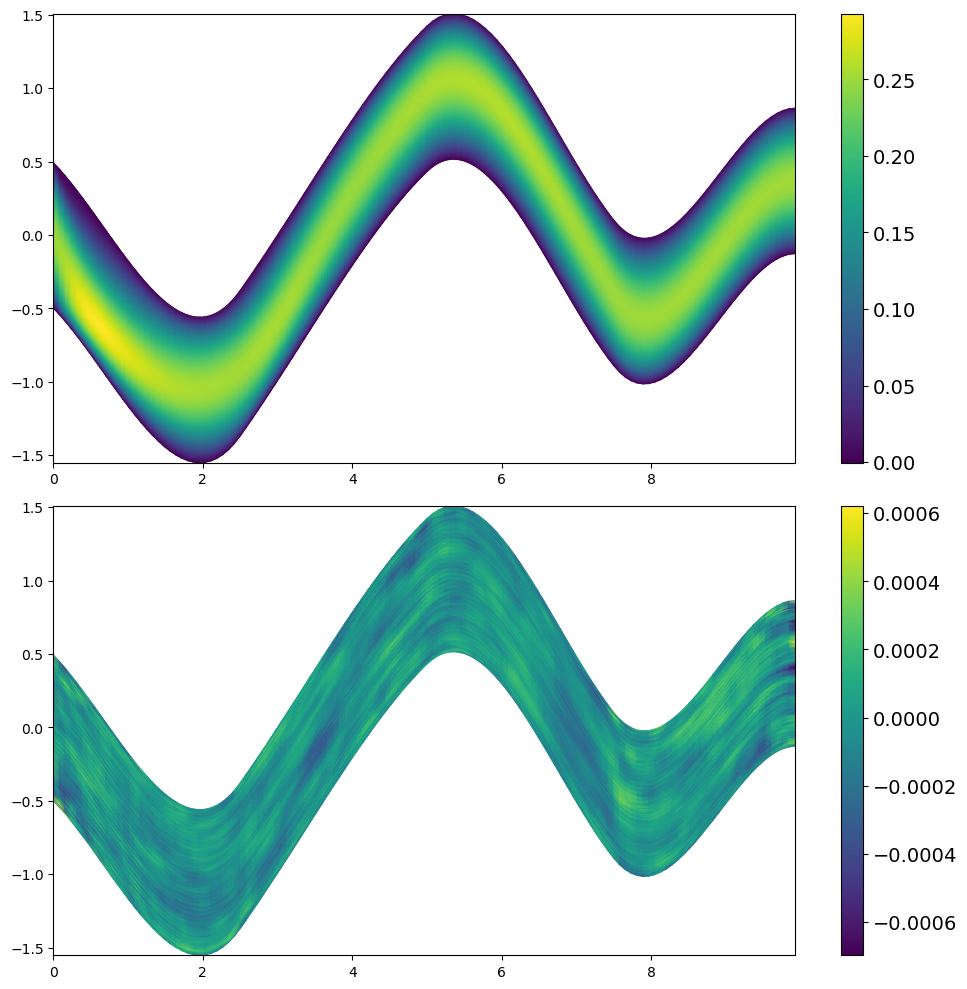

In [14]:
X = x_train[3, 0, :, :].squeeze().detach().cpu().numpy()
Y = x_train[3, 1, :, :].squeeze().detach().cpu().numpy()
truth = y_train[0].squeeze().detach().cpu().numpy()
pred = out.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))  # Changed figsize to (10, 10) for a smaller figure

cax_truth = ax[0].pcolormesh(X, Y, truth, shading='gouraud')
cax_pred = ax[1].pcolormesh(X, Y, pred-truth, shading='gouraud')

# Added colorbars with increased font size
cb_truth = fig.colorbar(cax_truth, ax=ax[0])
cb_pred = fig.colorbar(cax_pred, ax=ax[1])

cb_truth.ax.tick_params(labelsize=14)  # Increase font size for colorbar
cb_pred.ax.tick_params(labelsize=14)   # Increase font size for colorbar

plt.tight_layout()
plt.show()


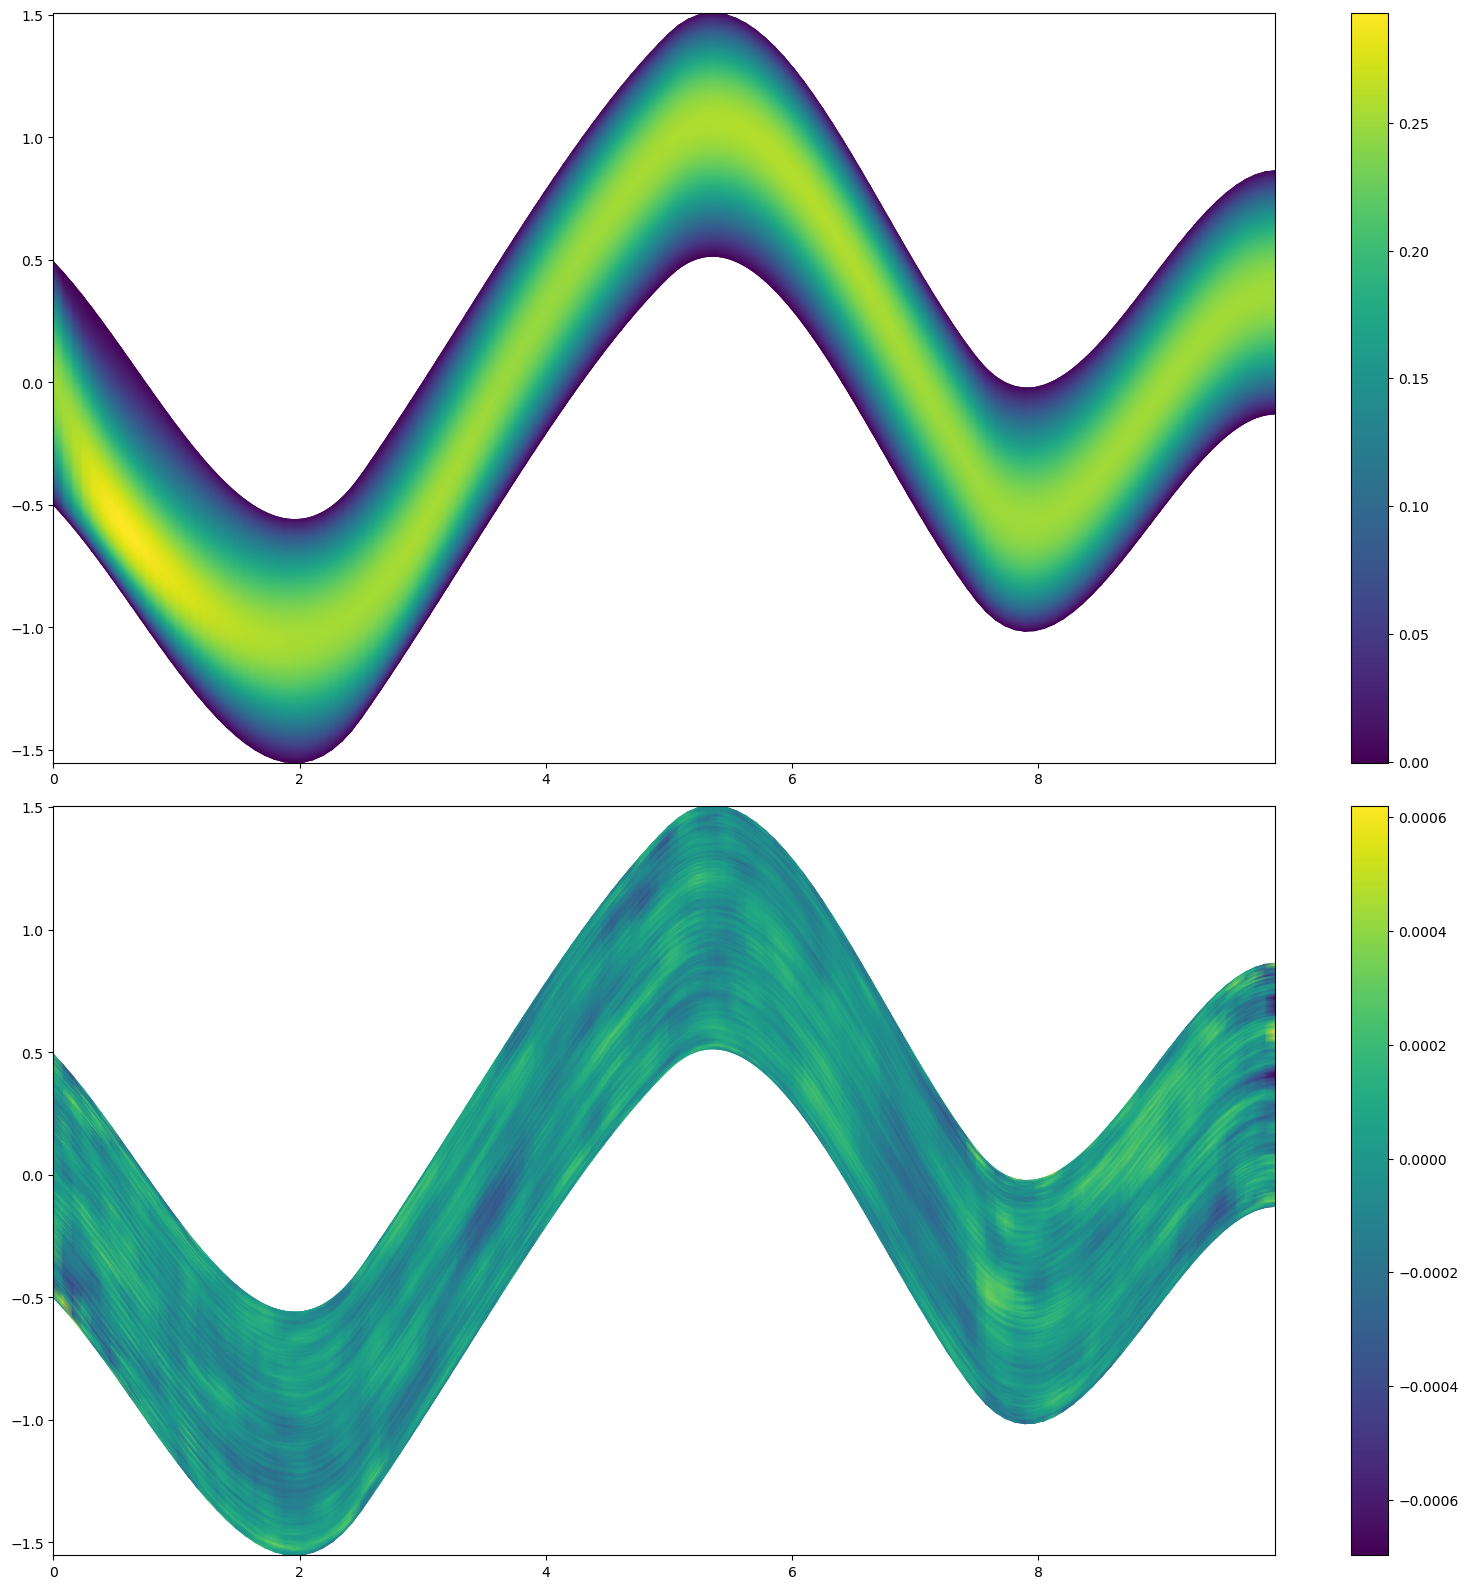

In [13]:
X = x_train[3, 0, :, :].squeeze().detach().cpu().numpy()
Y = x_train[3, 1, :, :].squeeze().detach().cpu().numpy()
truth = y_train[0].squeeze().detach().cpu().numpy()
pred = out.squeeze().detach().cpu().numpy()
# X_square = torch.meshgrid(torch.linspace(0, 1, s1), torch.linspace(0, 1, s2))[0].numpy()
# Y_square = torch.meshgrid(torch.linspace(0, 1, s1), torch.linspace(0, 1, s2))[1].numpy()
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))
ax[0].pcolormesh(X, Y, truth, shading='gouraud')
# ax[1].pcolormesh(X_square, Y_square, truth, shading='gouraud')
ax[1].pcolormesh(X, Y, pred-truth, shading='gouraud')
# show colorbar and large font size

fig.colorbar(ax[0].pcolormesh(X, Y, truth, shading='gouraud'))
fig.colorbar(ax[1].pcolormesh(X, Y, pred-truth, shading='gouraud'))
# change figure scale

plt.tight_layout()
plt.show()
fig.show()

In [ ]:

################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)

            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    if ep%step_size==0:
        # torch.save(model, '../model/pipe_' + str(ep))
        X = x[0, :, :, 0].squeeze().detach().cpu().numpy()
        Y = x[0, :, :, 1].squeeze().detach().cpu().numpy()
        truth = y[0].squeeze().detach().cpu().numpy()
        pred = out[0].squeeze().detach().cpu().numpy()

        fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
        ax[0].pcolormesh(X, Y, truth, shading='gouraud')
        ax[1].pcolormesh(X, Y, pred, shading='gouraud')
        ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
        fig.show()




In [42]:
"""
@author: Zongyi Li and Daniel Zhengyu Huang
"""

import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width)  # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


################################################################
# configs
################################################################
INPUT_X = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_X.npy'
INPUT_Y = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_Y.npy'
OUTPUT_Sigma = '/ibex/ai/home/liux0t/Xinliang/FMM/Pipe_Q.npy'

ntrain = 1000
ntest = 200
N = 1200

batch_size = 20
learning_rate = 6e-4

epochs = 501
step_size = 100
gamma = 0.5

modes = 12
width = 32

r1 = 1
r2 = 1
s1 = int(((129 - 1) / r1) )
s2 = int(((129 - 1) / r2) )

################################################################
# load data and data normalization
################################################################
inputX = np.load(INPUT_X)
inputX = torch.tensor(inputX, dtype=torch.float)
inputY = np.load(INPUT_Y)
inputY = torch.tensor(inputY, dtype=torch.float)
input = torch.stack([inputX, inputY], dim=-1)

output = np.load(OUTPUT_Sigma)[:, 0]
output = torch.tensor(output, dtype=torch.float)

x_train = input[:N][:ntrain, ::r1, ::r2][:, :s1, :s2]
y_train = output[:N][:ntrain, ::r1, ::r2][:, :s1, :s2]
x_test = input[:N][-ntest:, ::r1, ::r2][:, :s1, :s2]
y_test = output[:N][-ntest:, ::r1, ::r2][:, :s1, :s2]
x_train = x_train.reshape(ntrain, s1, s2, 2)
x_test = x_test.reshape(ntest, s1, s2, 2)

x_train = x_train.permute(0, 3, 1, 2).contiguous()
x_test = x_test.permute(0, 3, 1, 2).contiguous()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

################################################################
# training and evaluation
################################################################
model = MgNet(num_layer=4, num_channel_u=24, num_channel_f=24, num_classes=1, num_iteration=[2, 2, 2, 2, 2]).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)

            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    # if ep%step_size==0:
    #     # torch.save(model, '../model/pipe_' + str(ep))
    #     X = x[0, :, :, 0].squeeze().detach().cpu().numpy()
    #     Y = x[0, :, :, 1].squeeze().detach().cpu().numpy()
    #     truth = y[0].squeeze().detach().cpu().numpy()
    #     pred = out[0].squeeze().detach().cpu().numpy()

    #     fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
    #     ax[0].pcolormesh(X, Y, truth, shading='gouraud')
    #     ax[1].pcolormesh(X, Y, pred, shading='gouraud')
    #     ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
    #     fig.show()




946697
0 10.44208518229425 0.36114308071136475 0.30175902366638185
1 10.230930417776108 0.23889433479309083 0.17472787618637084
2 10.382235862314701 0.14775487661361694 0.14320884227752687
3 10.127765566110611 0.1264880609512329 0.11993668913841248
4 10.001738712191582 0.08345169270038605 0.06893993139266968
5 10.399186426773667 0.06272410571575165 0.05365219861268997
6 10.257958808913827 0.05109192371368408 0.047022551596164704
7 10.411929799243808 0.04364701777696609 0.04299939900636673
8 10.271789139136672 0.037950011640787124 0.042157307267189026
9 10.179314011707902 0.032443457067012786 0.03146996170282364
10 10.427551550790668 0.03500188636779785 0.033822359144687654
11 10.413830434903502 0.03082980892062187 0.04328782439231873
12 10.414733393117785 0.029215505093336105 0.029220804274082184
13 10.5193623714149 0.024042406886816026 0.02389769211411476
14 10.188471026718616 0.02428507661819458 0.023534701466560365
15 10.446104651317 0.02393292000889778 0.019835728853940963
16 10.26

In [ ]:
X = np.arange(129)
Y = np.arange(129)
X, Y = np.meshgrid(X,Y)   # create a mesh
U = truth
# u1 = torch.reshape(u1, (N, N)).detach().cpu().numpy()
# u2 = torch.reshape(u2, (N, N)).detach().cpu().numpy()
# plot the surface a

fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Plot')

# ax1 = fig.add_subplot(132, projection='3d')
# ax1.plot_surface(X, Y, u1, cmap='coolwarm')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.set_title('Surface Plot')

# ax1 = fig.add_subplot(133, projection='3d')
# ax1.plot_surface(X, Y, u2, cmap='coolwarm')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.set_title('Surface Plot')

# Show the plot
plt.show()

In [ ]:
truth.shape

In [ ]:
class HSloss_d(nn.MSELoss):
    def __init__(self, reduction='mean'):
        super().__init__(reduction=reduction)
    
    def forward(self, x, y):
        temp = x - y
        z0, z1 = torch.gradient(temp, dim=(-2, -1), spacing=1/x.size(-1)) 
        agg = 10*temp**2 + z0**2 + z1**2
        loss = torch.mean(torch.sqrt(torch.sum(agg, dim=(-2, -1))))  
        return loss

class HSloss_d_2(nn.MSELoss):
    def __init__(self, reduction='mean'):
        super().__init__(reduction=reduction)
    
    def forward(self, x, y):
        temp = x - y
        z0, z1 = torch.gradient(temp, dim=(-2, -1), spacing=1/x.size(-1)) 
        agg = temp**2 + z0**2 + z1**2
        yg1, yg2 = torch.gradient(y, dim=(-2, -1), spacing=1/x.size(-1)) 
        aggy = y**2 + yg1**2 + yg2**2
        loss = torch.mean(torch.sqrt(torch.sum(agg, dim=(-2, -1)))/torch.sqrt(torch.sum(aggy, dim=(-2, -1))))  
        return loss 

In [ ]:
loss_fun = HSloss_d()
loss = loss_fun(out, y)


In [ ]:
loss

In [ ]:
myloss(out, y)

In [ ]:
################################################################
# training and evaluation
################################################################
width = 64
model = SpectralDecoder(lift=2, modes=modes, width=width, padding=8, resolution=129, kernel_type='c', init_scale=1.5).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        loss = loss_fun(out, y)
        # err = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)

            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    # if ep%step_size==0:
    #     # torch.save(model, '../model/pipe_' + str(ep))
    #     X = x[0, :, :, 0].squeeze().detach().cpu().numpy()
    #     Y = x[0, :, :, 1].squeeze().detach().cpu().numpy()
    #     truth = y[0].squeeze().detach().cpu().numpy()
    #     pred = out[0].squeeze().detach().cpu().numpy()

    #     fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
    #     ax[0].pcolormesh(X, Y, truth, shading='gouraud')
    #     ax[1].pcolormesh(X, Y, pred, shading='gouraud')
    #     ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
    #     fig.show()


In [ ]:
################################################################
# training and evaluation
################################################################
width = 32
model = SpectralDecoder(lift=2, modes=modes, width=width, padding=8, resolution=129, kernel_type='c', init_scale=1.5).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        loss = loss_fun(out, y)
        # err = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)

            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    # if ep%step_size==0:
    #     # torch.save(model, '../model/pipe_' + str(ep))
    #     X = x[0, :, :, 0].squeeze().detach().cpu().numpy()
    #     Y = x[0, :, :, 1].squeeze().detach().cpu().numpy()
    #     truth = y[0].squeeze().detach().cpu().numpy()
    #     pred = out[0].squeeze().detach().cpu().numpy()

    #     fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
    #     ax[0].pcolormesh(X, Y, truth, shading='gouraud')
    #     ax[1].pcolormesh(X, Y, pred, shading='gouraud')
    #     ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
    #     fig.show()


In [ ]:
out.shape

In [ ]:
x.shape

In [ ]:
X = x[0, :, :, 0].squeeze().detach().cpu().numpy()
Y = x[0, :, :, 1].squeeze().detach().cpu().numpy()
truth = y[0].squeeze().detach().cpu().numpy()
pred = out[0].squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
ax[0].pcolormesh(X, Y, truth, shading='gouraud')
ax[1].pcolormesh(X, Y, pred, shading='gouraud')
ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
fig.show()

In [ ]:
X = x[3, :, :, 0].squeeze().detach().cpu().numpy()
Y = x[3, :, :, 1].squeeze().detach().cpu().numpy()
truth = y[0].squeeze().detach().cpu().numpy()
pred = out[0].squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(nrows=3, figsize=(16, 16))
ax[0].pcolormesh(X, Y, truth, shading='gouraud')
ax[1].pcolormesh(X, Y, pred, shading='gouraud')
ax[2].pcolormesh(X, Y, pred-truth, shading='gouraud')
fig.show()